# Projeto 3

<b>Tema:</b> Estimar o retorno financeiro de um filme

<b>Técnica:</b> Regressão Linear

<b>Grupo:</b> Lucas Leal Vale, Matheus Augusto Soares, Rafael Almada
___

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

___
## _Introdução_

Neste projeto, o objetivo final do grupo, é conseguir estimar com certa precisão o retorno financeiro de um filme hipotético X dado algumas características do mesmo. Para isso estamos utilizando uma base de dados que pode ser encontrada no link abaixo:

Link do DataSet: https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv

___

### _Filtrando a Base de Dados_

In [2]:
#Limpando DataFrame
movies=pd.read_csv('movies_metadata.csv', low_memory=False)
df=movies.loc[:, {'id','original_title','original_language','genres','popularity','runtime','budget','revenue',
                 'production_companies','production_countries', 'release_date','vote_average',}]
df.head(3)

,original_language,budget,revenue,runtime,release_date,vote_average,genres,production_countries,production_companies,id,original_title,popularity
0,en,30000000,373554033.0,81.0,1995-10-30,7.7,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Pixar Animation Studios', 'id': 3}]",862,Toy Story,21.946943
1,en,65000000,262797249.0,104.0,1995-12-15,6.9,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'TriStar Pictures', 'id': 559}, {'na...",8844,Jumanji,17.015539
2,en,0,0.0,101.0,1995-12-22,6.5,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602,Grumpier Old Men,11.7129


In [3]:
# Tirando valores de budget que estavam como arquivos de imagens e não números
df=df.drop([19730, 29503, 35587])

# Colocando algumas colunas como float para analisá-las quantitativamente
df['budget']=df['budget'].astype('float64')
df['popularity']=df['popularity'].astype('float64')
df['id']=df['id'].astype('float64')
df.dtypes

original_language        object
budget                  float64
revenue                 float64
runtime                 float64
release_date             object
vote_average            float64
genres                   object
production_countries     object
production_companies     object
id                      float64
original_title           object
popularity              float64
dtype: object

In [4]:
#Ordenando em ordem crescente de acordo com o id, e filtrando valores 0 das variáveis float
df=df[(df['revenue']>0) & (df['budget']>0)  & (df['runtime']>0)]
df=df.sort_values(['id'], ascending=[True])
df['id']=df['id'].astype('int')

df=df.set_index('id')

___
## _Análise Exploratória dos Dados_

Aqui começamos a análise exploratória dos dados. Nosso objetivo nessa etapa é analisar como a nossa base de dados se comporta, para que assim, ao decorrer do código, é importante que estejamos cientes de como cada variável se organiza.

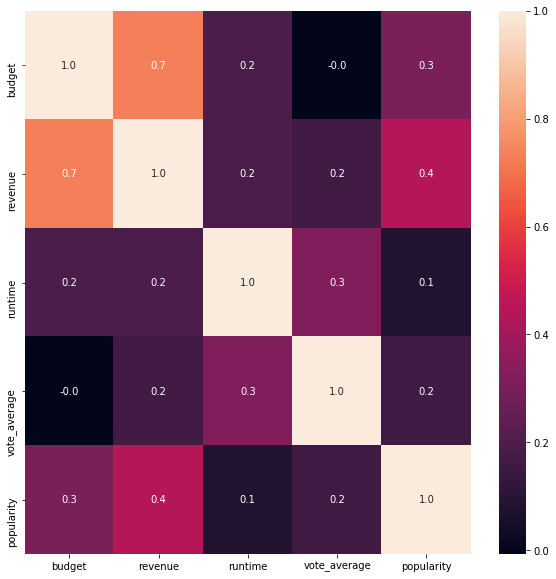

In [5]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot = True,fmt='.1f')

Com o gráfico acima obtemos os resultados das correlações entre cada coluna (variável). Como queremos achar uma forma de estimar o retorno financeiro de um filme ao final do projeto, precisamos analisar as variáveis em relação à variável 'Revenue'. Dessa forma percebemos que, em nossa regressão, quanto maior a correlação de uma variável X em relação à nossa variável fixada (revenue), quanto mais próxima a 1, seja positiva ou negativamente, mais importante será na nossa regressão tal variável.

Logo, das variáveis escolhidas até o momento, podemos dizer que em ordem de maior relevância no cálculo da nossa regressão estão em ordem decrescente, primeiro Budget (ou custo de produção do filme), o qual era esperado ter grande impacto no retorno do mesmo. Logo em seguida vem Popularity ou a popularidade do filme (quanto falam dele). Depois, juntos, seguem as variáveis Runtime (Tempo corrido em tela do filme) e Vote Average (Nota do filme dada pela comunidade).

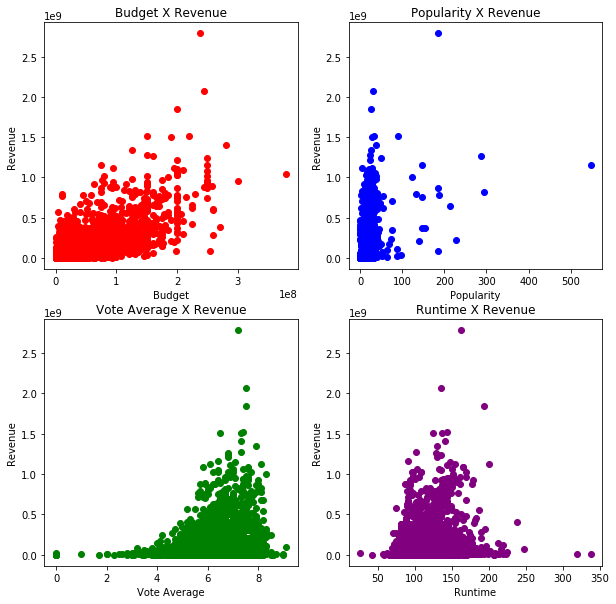

In [6]:
# Alguns ScatterPlot para analisar a dispersão dos dados em relação a revenue
fig=plt.figure(figsize=(10, 10))

# Budget X Revenue
plt.subplot(221)
plt.scatter(df.budget,df.revenue, color='red')
plt.title('Budget X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Budget')

# Popularity X Revenue
plt.subplot(222)
plt.scatter(df.popularity,df.revenue, color='blue')
plt.title('Popularity X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Popularity')

# Vote Average X Revenue
plt.subplot(223)
plt.scatter(df.vote_average,df.revenue, color='green')
plt.title('Vote Average X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Vote Average')

#Runtime X Revenue
plt.subplot(224)
plt.scatter(df.runtime,df.revenue, color='purple')
plt.title('Runtime X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Runtime')

plt.show()

Nos gráficos de dispersão acima podemos verificar o quão dispersos são os dados e visualiza-los em relação ao retorno financeiro (revenue). Percebemos que, como já visto em suas respectivas correlações, todos são positivos, logo quando o retorno é maior, a váriavel em questão (seja budget, popularidade ou tempo corrido) também é maior. A diferença desse gráfico para a tabela de correlações é que como já diz o nome deste, podemos verificar a disperção das variáveis.

A parte curiosa disso é que alguns filmes conseguem um retorno alto, mesmo tendo uma produção barata seja por motivos quaisquer, como é o caso de alguns filmes de terror que por não usar muito dinheiro, sua credibilidade aumenta, aumentando no caso também o fator "Terror" e assim chegando a cada vez mais cinemas e conseguindo um retorno de um filme blockbuster produzido por alguma empresa grande. Além disso, os gráficos nos mostram que um filme popular entre as pessoas, não necessariamente vai trazer um retorno alto.

Também temos dois gráficos que parecem um pouco com uma distribuição normal, possuindo uma média de tempo corrido de tela e classificação (ou nota) do público para o filme para um retorno maior do longa.

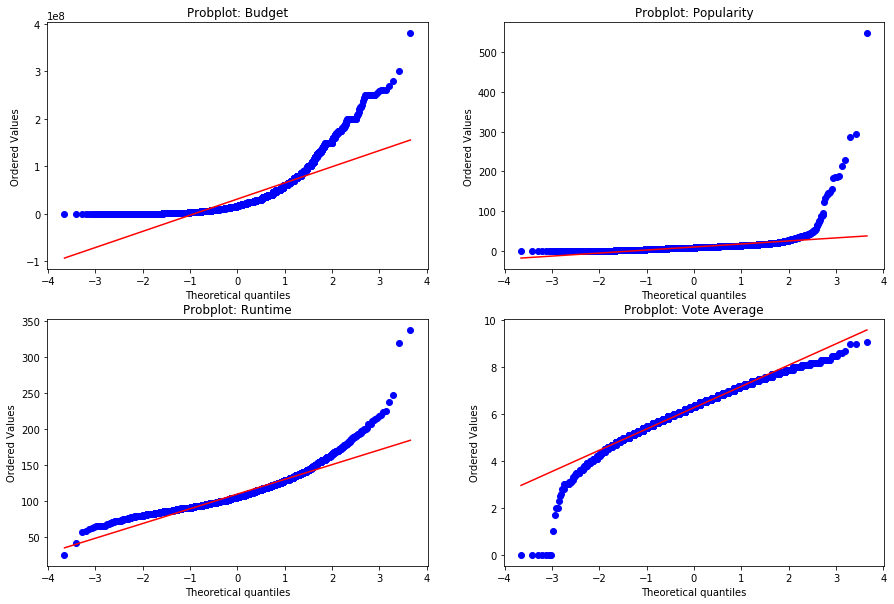

In [7]:
# Gráficos que verificam se alguma das variáveis analisadas tende a uma distribuição normal
fig=plt.figure(figsize=(15, 10))

plt.subplot(221)
stats.probplot(df.budget, plot=plt)
plt.title('Probplot: Budget')

plt.subplot(222)
stats.probplot(df.popularity, plot=plt)
plt.title('Probplot: Popularity')

plt.subplot(223)
stats.probplot(df.runtime, plot=plt)
plt.title('Probplot: Runtime')

plt.subplot(224)
stats.probplot(df.vote_average, plot=plt)
plt.title('Probplot: Vote Average')
plt.show()

Os Probability Plots acima (gráficos que medem o quanto uma base e dados se distribui conforme uma distribuição Gaussiana ou Normal), nos mostram que nenhum das variáveis se comporta como uma. A hipótese que tínhamos anteriormente nos gráficos de dispersão, de que as variáveis "Runtime" (tempo corrido de tela) e "Vote Average" (nota do filme pelo público) seguem tal distribuição não se confirmam. Pelo incrível que pareça, a variável que mais tende a tal é a de popularidade do filme com o público, independendo de sua nota dada pelo mesmo. Porém não se pode dizer que nenhuma das variáveis se distribui de forma gaussiana, anulando essas hipóteses.

Agora podemos seguir adiante da Análise exploratória dos dados.

___
## Iniciando a Regressão Linear Múltipla

In [8]:
X=df[['budget', 'popularity', 'runtime', 'vote_average']]
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2035.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:32:08   Log-Likelihood:            -1.0677e+05
No. Observations:                5369   AIC:                         2.135e+05
Df Residuals:                    5364   BIC:                         2.136e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.761e+08   1.08e+07    -16.266      0.000   -1.97e+08   -1.55e+08
budget           2.7534      0.038     71.942      0.000       2.678       2.828
popularity    2.566e+06    1.1e+05     23.235      0.000    2.35e+06    2.78e+06
runtime       2225.7085   7.17e+04      0.031      0.975   -1.38e+05    1.43e+05
vote_average  2.478e+07   1.66e+06     14.915      0.000    2.15e+07     2.8e+07
==============================================================================
Omnibus:                     4175.948   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229343.981
Skew:                           3.245   Prob(JB):                         0.00
Kurtosis:                      34.354   Cond. No.                     3.87e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Com o primeiro teste de regressão linear múltipla feita na célula acima (utilizando a biblioteca Statsmodels), conseguimos ter uma visão inicial do caminho que devemos seguir a partir de agora. Vamos analisar!

Primeiro vamos olhar para o nosso **`R`²** que possui o valor de **0.603**. Dado esse valor, sabemos que a regressão ainda tem muito a ser melhorada (quanto mais próximo de **1** o **`R²`**, mais preciso está o modelo), devemos olhar para mais variáveis que possam explicar nosso modelo. No caso utilizamos por enquanto apenas as variáveis quantitativas, mas ainda temos algumas Qualitativas para implementar em nosso modelo.

A segunda coisa que devemos dar nossa atenção são as **`P-values`**, sendo que todas as variáveis, exceto uma, possuem um **`p-value`** de **0**, porém temos _runtime_ que possui **0.975**. O problema de um valor alto nesse caso é porque isso prova que a variável em questão está mais atrapalhando do que ajudando a precisão da nossa regressão.

As últimas coisas que devemos dar enfoque na primeira análise do modelo são a **`Prob(F-statistic)`**, a **`Prob(Omnibus)`** e a **`Prob(Jarque-Bera)`**. No caso a **`F-statistic`** coloca sob a hipótese nula de que todos os $\beta$ 's (a não ser o $\beta_0$) são iguais a zero e verifica o quão próximo tal modelo estaria do então calculado. Dado que a probabildade é **0**, logo podemos afirmar que o modelo precisa de tais variáveis.

Já a **`Prob(Omnibus)`** testa se os resíduos do nosso modelo tendem a uma normal. É importante que os resíduos tendam a uma distribuição gaussiana, pois se os resíduos não se distribuírem como uma normal, então a hipótese de que eles se comportam como uma amostra aleatória de uma população maior será dada como uma mentira e isso comprometerá totalmente a veracidade da regressão. No caso temos **$Prob(Omnibus) = 0.00$**, sendo assim não podemos confiar neste modelo. 

Ainda temos a **`Prob(JB)`** que realiza o teste chamado **`Jarque-Bera`**, que utiliza as mesmas hipóteses que o teste **`Omnibus`**, porém utilizando um método diferente, fazendo uso do grau de assimetria da distribuição (Skew) e do grau de achatamento da mesma (Kurtosis). Um **`Skew`** mais próximo de **0** e um **`Kurtosis`** mais próximo de **3** são os mais precisos para uma distribuição gaussiana dos resíduos, porém ainda temos resíduos _"reprovados"_ em ambos os testes.

In [9]:
# Removendo a coluna df.runtime
df=df.loc[:,['release_date','popularity','original_title','vote_average','original_language','revenue','production_countries',
            'genres','production_companies','budget']]
df.head(3)

,release_date,popularity,original_title,vote_average,original_language,revenue,production_countries,genres,production_companies,budget
id,,,,,,,,,,
5,1995-12-09,9.026586,Four Rooms,6.5,en,4300000.0,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...","[{'name': 'Miramax Films', 'id': 14}, {'name':...",4000000.0
11,1977-05-25,42.149697,Star Wars,8.1,en,775398007.0,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",11000000.0
12,2003-05-30,25.497794,Finding Nemo,7.6,en,940335536.0,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pixar Animation Studios', 'id': 3}]",94000000.0


In [10]:
# As colunas de empresas e países que produziram estavam em um dicionário que estava dentro de uma string, então montamos a 
# função abaixo que transformam o conteudo de cada filme em uma lista a ser manipulada
def transforma(df,parametro):
    def dicio(df): #Ex: df = df.production_countries ; parametro = 'iso_3166_1'
        count=0
        dicio=''
        for i in df:
            if i=="{":
                count=1
            if count==1:
                dicio+=i
            if i=="}":
                dicio+=';'
                count=2
            if i=="]":
                break
        dicio=dicio.split(';')
        del(dicio[-1]) #removendo string vazia
        return dicio
# Agora precisamos percorrer todos os filmes com a função dicio    
    dicio2=[]
    for i in df.index:
        dicio2.append(dicio(df[i]))
# Agora, para cada filme na lista dicio2, iremos transformar cada empresa/país de string para dicionário
    for x in range(len(dicio2)):
        a=[]
        #country=[]
        for filme in dicio2[x]:
            a.append(eval(filme))
        dicio2[x]=a
# Iremos manipular os dicionários e extrair somente as siglas dos países/empresas
    country=[]
    for filme in dicio2:
        film=[]
        for pais in filme:
            sigla=pais[parametro]
            film.append(sigla)
        country.append(film)
    return country

In [11]:
# Retirando a variavel run_time para melhorar a qualidade da regressão

In [12]:
X=df[['budget', 'popularity', 'vote_average']]
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2714.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:32:08   Log-Likelihood:            -1.0677e+05
No. Observations:                5369   AIC:                         2.135e+05
Df Residuals:                    5365   BIC:                         2.136e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.76e+08   9.94e+06    -17.710      0.000   -1.95e+08   -1.57e+08
budget           2.7536      0.037     73.465      0.000       2.680       2.827
popularity    2.566e+06    1.1e+05     23.245      0.000    2.35e+06    2.78e+06
vote_average   2.48e+07   1.57e+06     15.780      0.000    2.17e+07    2.79e+07
==============================================================================
Omnibus:                     4176.172   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229390.636
Skew:                           3.245   Prob(JB):                         0.00
Kurtosis:                      34.357   Cond. No.                     3.57e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Agora que a regressão já foi gerada é necessário tentar melhorá-la com as colunas qualitativas do dataframe. E para poder fazer uso delas é necessário trata-las, primeiro transformando em strings simples e depois adicionando no dataframe base 'df'.

In [13]:
# Aplicando a nossa função e adicionando o nome dos países de produção em uma coluna mais fácil de ser utilizada na regressão

In [14]:
# Arrumando a coluna de pais de produção para ser utilizada na regressão
country=transforma(df.production_countries,'iso_3166_1')
country=pd.Series(country)
df['country']=country

In [15]:
# Precisamos retirar '[]' das células de df.country
df['country']=df.country.astype(str).str.replace('\[|\]|\'', '')

In [16]:
country=pd.get_dummies(df.country)

In [17]:
df=df.merge(country, how='inner', on='id',)

In [18]:
# Arrumando a coluna de linguas para ser utilizada na regressão
language=pd.get_dummies(df.original_language)

In [19]:
# adicionando novo dataframe ao antigo com a lingua original de cada pais
language=language.add_suffix('_')
df=df.merge(language, how='inner', on='id',)

In [20]:
# Criando um novo dataframe para ver se a o pais de origem ira melhorar nossa regressao, devido ao significativo aumento de colunas
# sera mais facil tirar aquelas que nao queremos ao inves de falar as que queremos dentro da regressao
dfg=df
dfg=dfg.drop(columns=['release_date','original_title','original_language','production_countries','genres','production_companies','country','revenue'])

In [21]:
X=dfg
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     45.17
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:32:08   Log-Likelihood:            -1.0828e+05
No. Observations:                5453   AIC:                         2.169e+05
Df Residuals:                    5261   BIC:                         2.182e+05
Df Model:                         191                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -1.524e+08    1.7e+07     -8.970      0.000   -1.86e+08   -1.19e+08
popularity                          2.581e+06    1.1e+05     23.492      0.000    2.37e+06     2.8e+06
vote_average                        2.281e+07   1.66e+06     13.727      0.000    1.96e+07    2.61e+07
budget                                 2.7436      0.038     72.010      0.000       2.669       2.818
                                    3.288e+07   3.51e+07      0.937      0.349   -3.59e+07    1.02e+08
AE, US                              3.269e+07   1.03e+08      0.317      0.751   -1.69e+08    2.35e+08
AT, FR                             -4.031e+07   1.03e+08     -0.391      0.696   -2.43e+08    1.62e+08
AU                                  5.375e+07    5.2e+07      1.034      0.301   -4.82e+07    1.56e+08
AU, CA, US                          -6.35e+07   1.03e+08     -0.616      0.538   -2.66e+08    1.39e+08
AU, FR                             -4.118e+07   1.03e+08     -0.399      0.690   -2.43e+08    1.61e+08
AU, HK                             -5.457e+07   1.03e+08     -0.529      0.597   -2.57e+08    1.48e+08
AU, IN, GB, US                      3.892e+07   1.03e+08      0.377      0.706   -1.63e+08    2.41e+08
AU, US                             -6.616e+07   2.23e+07     -2.962      0.003    -1.1e+08   -2.24e+07
BE, FR, LU                          8.436e+07   1.03e+08      0.818      0.413   -1.18e+08    2.87e+08
BG, US                              1.815e+08   1.03e+08      1.760      0.079   -2.07e+07    3.84e+08
BR, PE, US                         -1.069e+08   1.03e+08     -1.037      0.300   -3.09e+08    9.52e+07
CA                                 -3.293e+07    4.3e+07     -0.766      0.444   -1.17e+08    5.13e+07
CA, CZ, DE, GB, US                  1.119e+08   1.03e+08      1.085      0.278   -9.03e+07    3.14e+08
CA, DE, US                          6.116e+07   1.03e+08      0.593      0.553   -1.41e+08    2.63e+08
CA, FR                             -1.331e+08   1.03e+08     -1.290      0.197   -3.35e+08    6.91e+07
CA, FR, GB                         -4.009e+07   7.31e+07     -0.548      0.583   -1.83e+08    1.03e+08
CA, FR, US                          5.555e+06   1.03e+08      0.054      0.957   -1.97e+08    2.08e+08
CA, GB, US                         -4.384e+06   1.03e+08     -0.043      0.966   -2.07e+08    1.98e+08
CA, GB, US, IT, ZA                 -5.689e+07   1.03e+08     -0.552      0.581   -2.59e+08    1.45e+08
CA, IE                             -1.149e+08   1.03e+08     -1.114      0.265   -3.17e+08    8.73e+07
CA, US                              1.853e+07   2.54e+07      0.729      0.466   -3.13e+07    6.83e+07
CH, US                               9.41e+07   1.04e+08      0.904      0.366    -1.1e+08    2.

In [22]:
companies=transforma(df.production_companies,'name')
companies=pd.Series(companies)
df['company']=companies
df['company']=df.company.astype(str).str.replace('\[|\]|\'', '')

In [23]:
compania=pd.get_dummies(df.company)
df=df.merge(compania, how='inner', on='id',)

In [24]:
dfg=df
dfg=dfg.drop(columns=['release_date','original_title','original_language','production_countries','genres','production_companies','country','company'])

In [25]:
X=dfg
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.302e+29
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:32:12   Log-Likelihood:                 87289.
No. Observations:                6893   AIC:                        -1.726e+05
Df Residuals:                    5910   BIC:                        -1.659e+05
Df Model:                         982                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 6.279e-07    1.4e-07      4.491      0.000    3.54e-07    9.02e-07
popularity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           -1.281e-08   9.48e-10    -13.511      0.000   -1.47e-08   -1.09e-08
vote_average                                                                                                                                                  